Results:
- Hudson Fst values were calculated
- Lower Fst values were generated by 'average of ratios' compared to 'ratio of averages' approach, similar to the original [Bhatta et al 2013 paper](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3759727/). Also, 'ratio of averages' is used in the [allel implementation of Fst averaging](https://scikit-allel.readthedocs.io/en/stable/_modules/allel/stats/fst.html#average_patterson_fst). 
- Top isolated populations are `AOcol`, `FRgam`, and `KE` - same trends observed in PCA and whole-genome dataset: https://github.com/malariagen/ag1000g-phase2-data-paper/blob/master/artwork/pairwise_fst.jpeg


In [1]:
%run common.ipynb

In [12]:
# files
OUT = 'data/fsts.csv'

In [2]:
# parameters
BLEN = 500 # block length for averaged Fst calculation

In [3]:
# concatenate variants from all amplicons into a single array
ampl_snps = list()
for ampl in callset:
    ampl_snps.append(callset[ampl]['genotype'])
ampl_snps = allel.GenotypeChunkedArray(np.concatenate(ampl_snps))
# # snps, samples, ploidy
ampl_snps.shape

(2112, 1142, 2)

In [4]:
# population allele counts
# assume samples in metadata and samples in genotyping data are aligned (worked for PCA)
grp = samples.groupby(["population"])
pop_ampl_ac = ampl_snps.count_alleles_subpops(grp.indices)
pop_ampl_ac

<AlleleCountsChunkedTable shape=(2112,) dtype=[('AOcol', '<i4', (2,)), ('BFcol', '<i4', (2,)), ('BFgam', '<i4', (2,)), ('CIcol', '<i4', (2,)), ('CMgam', '<i4', (2,)), ('FRgam', '<i4', (2,)), ('GAgam', '<i4', (2,)), ('GHcol', '<i4', (2,)), ('GHgam', '<i4', (2,)), ('GM', '<i4', (2,)), ('GNcol', '<i4', (2,)), ('GNgam', '<i4', (2,)), ('GQgam', '<i4', (2,)), ('GW', '<i4', (2,)), ('KE', '<i4', (2,)), ('UGgam', '<i4', (2,))]
   nbytes=264.0K cbytes=30.8K cratio=8.6
   values=allel.chunked.storage_zarr.ZarrTable>

## Fst calculation (default - ratio of averages)

In [5]:
def compute_pair_fst(pops):
    # unpack pops
    pop1, pop2 = pops
    # get allele counts
    ac1 = pop_ampl_ac[pop1]
    ac2 = pop_ampl_ac[pop2]
    # filter allele counts
    loc_asc = (ac1.is_segregating() & 
               ac2.is_segregating() & 
               (ac1.max_allele() <= 1) & 
               (ac2.max_allele() <= 1))
    ac1 = allel.AlleleCountsArray(ac1.compress(loc_asc, axis=0)[:, :2])
    ac2 = allel.AlleleCountsArray(ac2.compress(loc_asc, axis=0)[:, :2])
    # compute Fst
    num, den = allel.hudson_fst(ac1, ac2)
    
    return num, den, sum(loc_asc)

In [6]:
def compute_pairwise_fst(populations=populations):
    pairwise_fst = list()
    pairwise_ann = list()
    for pop1, pop2 in itertools.combinations(populations, 2):
        pops = tuple(sorted([pop1, pop2]))
        num, den, nsites = compute_pair_fst(pops=pops)
        fst = np.nansum(num) / np.nansum(den) # as suggested by allel docs
        pairwise_fst.append(fst)
        pairwise_ann.append('%.04f\n(%d)' % (fst, nsites))
    return pairwise_fst, pairwise_ann
fsts, anns = compute_pairwise_fst(populations)
anns[:2]

['0.1700\n(124)', '0.1039\n(110)']

In [14]:
fstsq = scipy.spatial.distance.squareform(fsts)
fstsq = pd.DataFrame(fstsq, index=populations, columns=populations)
fstsq.to_csv(OUT)

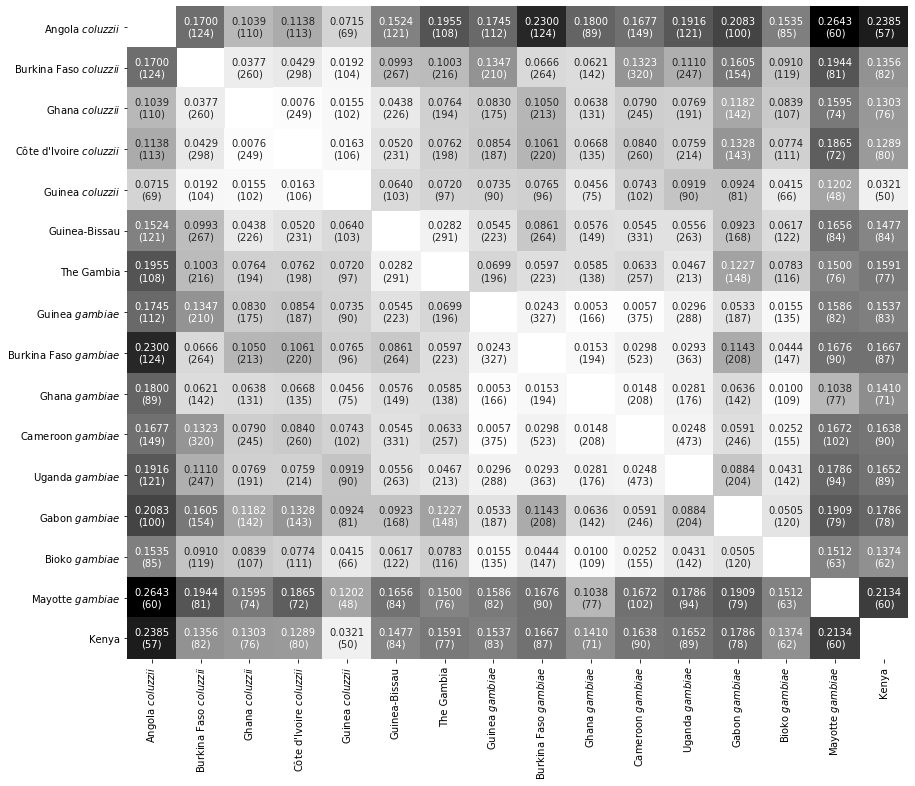

In [13]:
def plot_fsts(fsts, anns=None, populations=populations):
    # transform results
    fstsq = scipy.spatial.distance.squareform(fsts)
    if anns is None:
        annsq = np.around(fstsq, decimals=4)
    else:
        annsq = scipy.spatial.distance.squareform(anns)
    fstsq = pd.DataFrame(fstsq, index=populations, columns=populations)
    fstsq = fstsq.replace(0, np.nan)
    
    # plot as heatmap
    fig, ax = plt.subplots(figsize=(14, 12))
    g = sns.heatmap(fstsq, 
                    ax=ax,
                    cbar=False,
                    vmin=0, 
                    cmap='Greys',
                    fmt='',
                    annot=annsq);
    g.set_xticklabels([pop_labels[l.get_text()] for l in g.get_xticklabels()], rotation=90)
    g.set_yticklabels([pop_labels[l.get_text()] for l in g.get_yticklabels()], rotation=0);
plot_fsts(fsts, anns)

In [ ]:
annsq.to_cs


## Average of ratios Fst

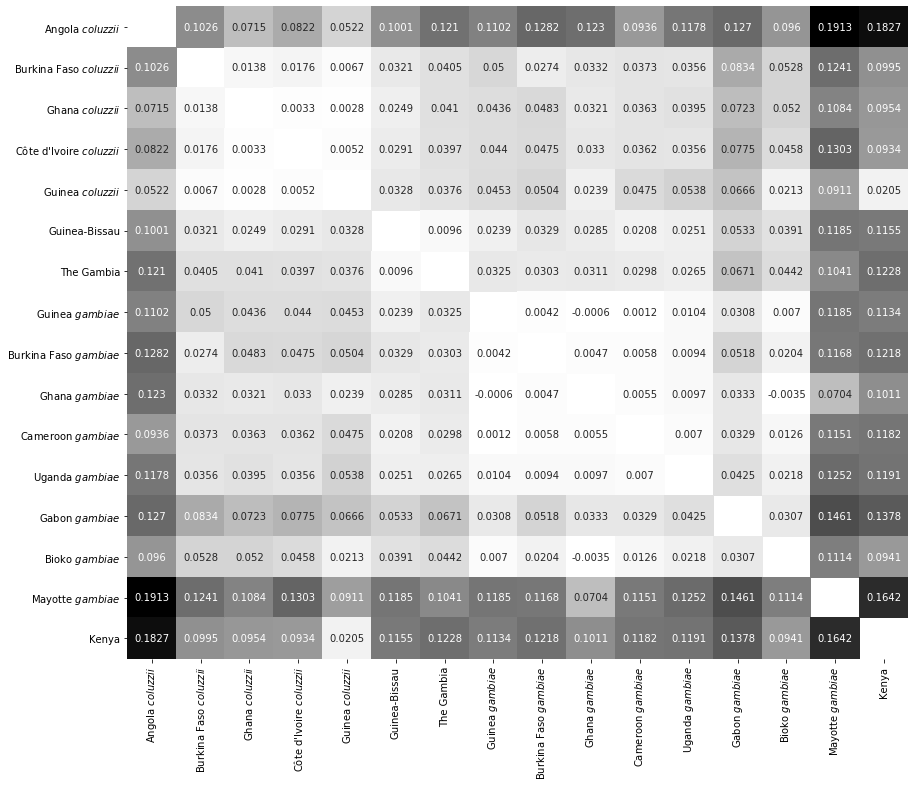

In [9]:
def compute_pairwise_ar_fst(populations=populations):
    pairwise_fst = list()
    for pop1, pop2 in itertools.combinations(populations, 2):
        pops = tuple(sorted([pop1, pop2]))
        num, den, nsites = compute_pair_fst(pops=pops)
        fst = num / den
        pairwise_fst.append(np.mean(fst))
    return pairwise_fst
plot_fsts(compute_pairwise_ar_fst(populations))

- Lower Fst values were generated by 'average of ratios' compared to 'ratio of averages' approach, similar to the original [Bhatta et al 2013 paper](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3759727/). Also, 'ratio of averages' is used in the [allel implementation of Fst averaging](https://scikit-allel.readthedocs.io/en/stable/_modules/allel/stats/fst.html#average_patterson_fst). 
- Top isolated populations are `AOcol`, `FRgam`, and `KE` - same trends observed in PCA and whole-genome dataset



## Sanity check - Fst calculation with average_hudson_fst function

In [10]:
def compute_average_pair_fst(pops):
    # unpack pops
    pop1, pop2 = pops
    # get allele counts
    ac1 = pop_ampl_ac[pop1]
    ac2 = pop_ampl_ac[pop2]
    # filter allele counts
    loc_asc = (ac1.is_segregating() & 
               ac2.is_segregating() & 
               (ac1.max_allele() <= 1) & 
               (ac2.max_allele() <= 1))
    ac1 = allel.AlleleCountsArray(ac1.compress(loc_asc, axis=0)[:, :2])
    ac2 = allel.AlleleCountsArray(ac2.compress(loc_asc, axis=0)[:, :2])
    # compute Fst
    # blen set to avoid division by zero
    fst, se, _, _ = allel.average_hudson_fst(ac1, ac2, blen=sum(loc_asc))
    
    return fst, se

/Users/am60/malaria/malariagen/binder/conda/envs/vector-ampseq-spp-aab8572/lib/python3.6/site-packages/allel/stats/misc.py:73: UserWarning: Warning: converting a masked element to nan.
  vj = np.array(vj)


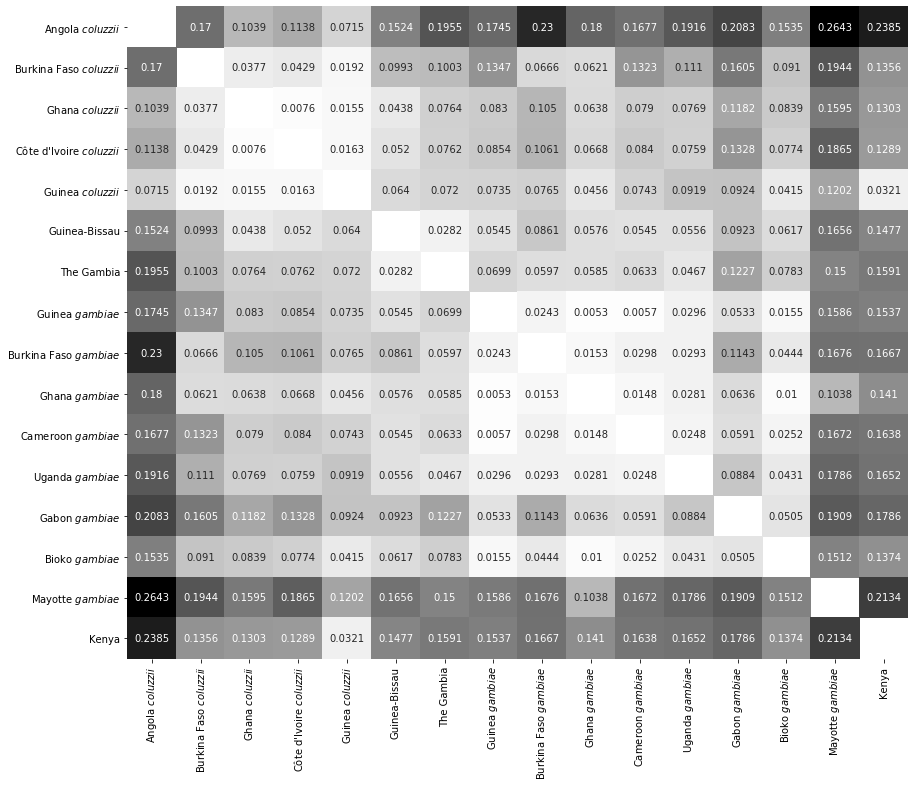

In [11]:
def compute_average_pairwise_fst(populations=populations):
    pairwise_fst = list()
    for pop1, pop2 in itertools.combinations(populations, 2):
        pops = tuple(sorted([pop1, pop2]))
        fst, se = compute_average_pair_fst(pops=pops)
        pairwise_fst.append(fst)
    return pairwise_fst
plot_fsts(compute_average_pairwise_fst(populations))